In [ ]:
!pip install sastrawi

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.5.0


In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku 

In [ ]:
# Import Dataset
import json
with open('dataset.json') as json_data:
    intents = json.load(json_data)

with open('validation.json') as json_data:
    validation = json.load(json_data)

In [ ]:
# Preprocessing text
import re
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
def string_preprocessing(text):
    # Delete punctuation mark and lowing the text
    text = re.sub(r'[^\w\s]', '', text)
    text.lower()

    # create stemmer
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    # stemming process
    text   = stemmer.stem(text)

    #Removing stopwords
    factory = StopWordRemoverFactory()
    stopword = factory.create_stop_word_remover()
    
    # Kalimat
    output = stopword.remove(text)

    return output

In [ ]:
# Labelling data
def labelling_data(intents):
  inputs, targets = [], []
  labels = []
  response_for_every_label = {}

  for intent in intents['intents']:
      if intent['intent'] not in labels:
          labels.append(intent['intent'])
      if intent['intent'] not in response_for_every_label:
          response_for_every_label[intent['intent']] = []
          
      for text in intent['utterances']:
          inputs.append(string_preprocessing(text))
          targets.append(intent['intent'])
          
      for response in intent['answers']:
          response_for_every_label[intent['intent']].append(response)
  return inputs, targets, response_for_every_label

In [ ]:
inputs, targets, response_for_every_label = labelling_data(intents)
validation_inputs, validation_targets, _ = labelling_data(validation)
all = inputs + validation_inputs

In [ ]:
# Tokenizing data
vocab_size = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(all)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(inputs)
max_length = np.max([len(d) for d in training_sequences]) + 5
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

validation_sequences = tokenizer.texts_to_sequences(validation_inputs)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [ ]:
# Saving tokenizing preprocessing
import pickle

# Pickle format
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# JSON format
tokenizer_json = tokenizer.to_json()
with open('tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

In [ ]:
# Creating target/label tensor
def tensor_label(targets):
  word={}
  categorical_target=[]
  counter=0
  for trg in targets:
      if trg not in word:
          word[trg]=counter
          counter+=1
      categorical_target.append(word[trg])
      
      target_tensor = ku.to_categorical(categorical_target, num_classes=len(word), dtype='int32')
      target_index_word =  dict((v,k) for k, v in word.items())
  return target_tensor, target_index_word

In [ ]:
target_training, target_index_word = tensor_label(targets)
target_validation, _ = tensor_label(validation_targets)

In [ ]:
# Recreate target index and response dictionary
responses = {}
for idx in target_index_word.keys():
  target_index_word[idx] = response_for_every_label[target_index_word[idx]][0]

In [ ]:
# Export response dict to json file
with open("response.json", "w") as outfile: 
    json.dump(target_index_word, outfile)

In [ ]:
# Tuning hyperparameter
total_words = len(tokenizer.word_index) + 1
embedding_dim = 512
epochs = 300
output_node = target_training.shape[1]

In [ ]:
# Creating model
model = Sequential()
model.add(Embedding(total_words, embedding_dim))
model.add(Bidirectional(LSTM(512, return_sequences = True)))
model.add(Dropout(0.5))
model.add(LSTM(256, return_sequences = True))
model.add(Dropout(0.4))
model.add(LSTM(128))
model.add(Dropout(0.4))
model.add(Dense(total_words, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(total_words/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(total_words/4, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(output_node, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, None, 512)         44544     
_________________________________________________________________
bidirectional_14 (Bidirectio (None, None, 1024)        4198400   
_________________________________________________________________
dropout_74 (Dropout)         (None, None, 1024)        0         
_________________________________________________________________
lstm_40 (LSTM)               (None, None, 256)         1311744   
_________________________________________________________________
dropout_75 (Dropout)         (None, None, 256)         0         
_________________________________________________________________
lstm_41 (LSTM)               (None, 128)               197120    
_________________________________________________________________
dropout_76 (Dropout)         (None, 128)             

In [ ]:
# Setting Callbacks

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.995):
      print("\nReached 99.5% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()

In [ ]:
# Training model
history = model.fit(training_padded,
                    target_training,
                    epochs=epochs,
                    callbacks = [callbacks],
                    validation_data = (validation_padded, target_validation))

Epoch 1/300
3/3 [==============================] - 20s 2s/step - loss: 3.4687 - accuracy: 0.1648 - val_loss: 3.4058 - val_accuracy: 0.2800
Epoch 2/300
3/3 [==============================] - 3s 861ms/step - loss: 3.3886 - accuracy: 0.1538 - val_loss: 3.3302 - val_accuracy: 0.2000
Epoch 3/300
3/3 [==============================] - 3s 861ms/step - loss: 3.3037 - accuracy: 0.2857 - val_loss: 3.2762 - val_accuracy: 0.2600
Epoch 4/300
3/3 [==============================] - 3s 852ms/step - loss: 3.2331 - accuracy: 0.2967 - val_loss: 3.2021 - val_accuracy: 0.2600
Epoch 5/300
3/3 [==============================] - 3s 864ms/step - loss: 3.1588 - accuracy: 0.2747 - val_loss: 3.1066 - val_accuracy: 0.2800
Epoch 6/300
3/3 [==============================] - 3s 859ms/step - loss: 3.0805 - accuracy: 0.3187 - val_loss: 3.0100 - val_accuracy: 0.4600
Epoch 7/300
3/3 [==============================] - 3s 834ms/step - loss: 2.9767 - accuracy: 0.3736 - val_loss: 2.8395 - val_accuracy: 0.4800
Epoch 8/300
3/3

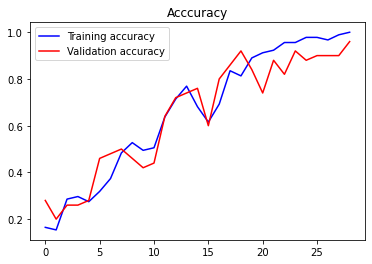

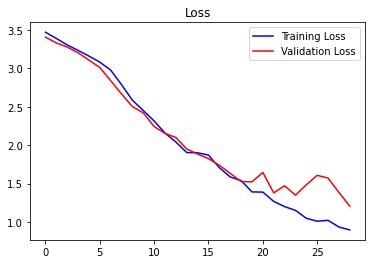

In [ ]:
# Plotting accuracy and loss
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Acccuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss')
plt.legend()

plt.show()

In [ ]:
# Inference
text = "saya baru saja menikah dan ingin memperbarui ktp saya"
text = string_preprocessing(text)
seq =  tokenizer.texts_to_sequences([text])
pad = pad_sequences(seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)
predicted = np.argmax(model.predict(pad, verbose=0))
target_index_word[predicted].split("\n")

['Untuk memperbarui informasi di e-KTP, Anda perlu menyiapkan e-KTP yang lama dan dokumen pendukung untuk data yang akan diubah seperti:',
 '-Surat nikah/putusan pengadilan untuk ganti status perkawinan',
 '-Surat keterangan RT/RW untuk pindah alamat domisili. Bisa diurus hingga tingkat kelurahan.',
 '-Ijazah, jika ingin menambah gelar',
 '-Surat keterangan dari instansi untuk mengubah status pekerjaan',
 '-Akta kelahiran',
 '-Fotokopi salinan surat keterangan dari pemuka agama untuk mengubah data agama jika ada perbedaan data.',
 'Kemudian Anda dapat membawa berkas-berkas tadi ke Dinas Kependudukan dan Pencatatan Sipil (Dukcapil), beberapa wilayah sudah bisa diurus di tingkat kelurahan tempat domisili Anda. Setelah petugas memperoleh persyaratan yang diperlukan, petugas akan memberikan resi untuk pengambilan e-KTP nanti. Tunggu maksimal 14 hari kerja untuk memperoleh e-KTP baru dengan membawa e-KTP lama, KK, dan resi.']

In [ ]:
# Saving ML model
saved_model_path = "./nlp.h5"

model.save(saved_model_path)

In [ ]:
!pip install tensorflowjs

In [ ]:
# Import model to json (optional, if don't want use h5 format)
!tensorflowjs_converter --input_format=keras {saved_model_path} ./